## Exercise 1: Build a TensorFlow Input Pipeline for Image Segmentation

In this exercise, you’ll construct a modular and efficient **TensorFlow input pipeline** designed for an image segmentation task involving high-resolution image-mask pairs.

You are provided with a dataset of RGB images and their corresponding single-channel segmentation masks — each with an original resolution of 2000×2992 pixels.

### **Goal**:
The objective is to prepare this image-mask dataset to train a machine learning model that can segment *in-focus* peas from each image.
These are the peas in contact with the inspection glass of a fluidized bed dryer, and they are identified in the dataset using segmentation masks. Here, is a one image and its segmentation mask.

In [2]:
from app.utils import load_show_images

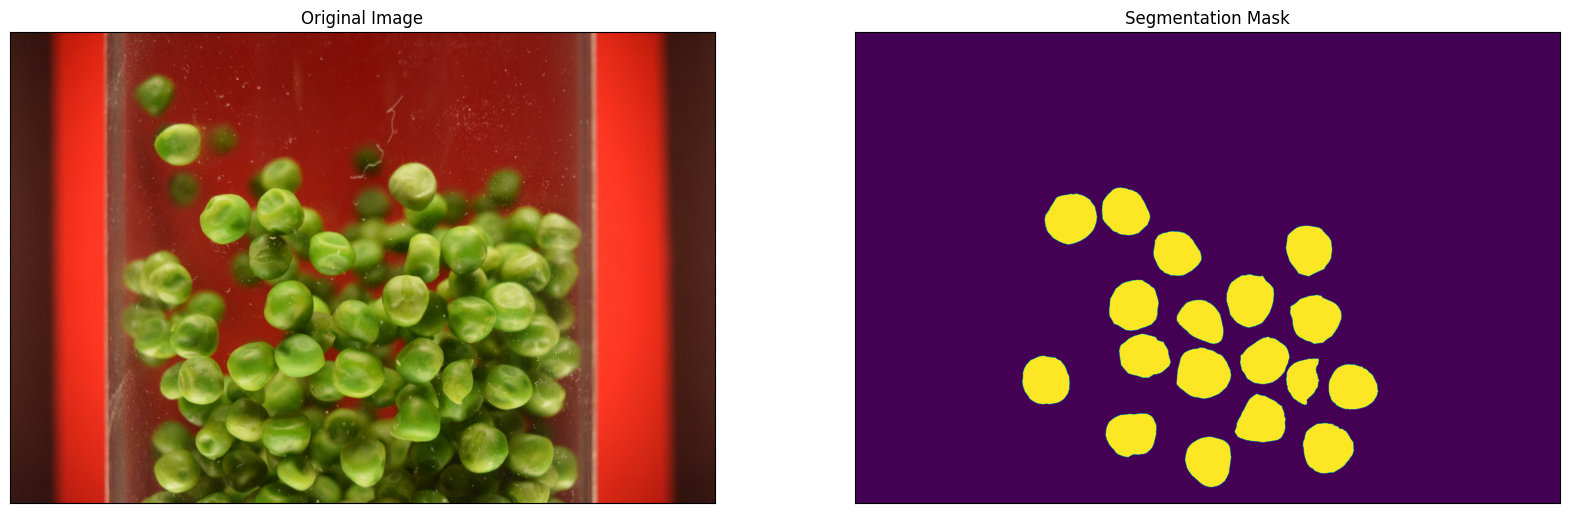

In [4]:
paths = ['sample_data/images/1.jpg', 'sample_data/masks/1.png']
titles = ['Original Image', 'Segmentation Mask']
load_show_images(image_paths=paths, channels=(3, 1), titles=titles)

### Real-World Constraints & Design Considerations

* Each original image contains a **2000×2000 region** representing only the inspection glass — this is the region we want to extract and feed into the model.
* However, due to GPU memory limitations, loading full-resolution images during training is not efficient. Instead, we’ll **resize** the cropped region to **1024×1024** pixels to strike a balance between preserving detail and optimizing performance.
* This resizing also enables the use of larger batch sizes, which can improve training stability.
* To ensure the input pipeline keeps up with model training speed, we’ll **shuffle** the data with a buffer size of 10, **batch** the data in groups of 2, and **enable prefetching** to maximize throughput.


### What You Need to Do

1. Crop a 2000×2000 centered region from each image and its corresponding mask.

2. Resize the cropped region to a target size of 1024×1024 pixels.

3. Use the following preprocessing configuration:

   * Image channels: **3** (RGB)
   * Mask channels: **1** (grayscale input before splitting)
   * **Batch size**: 2
   * **Shuffle buffer size**: 10
   * **Enable prefetching** to ensure smooth data loading

4. Implement the pipeline using the `ImageAndMaskDatasetBuilder` class.

5. Call `.run()` on your class instance to generate the final `tf.data.Dataset`.


> **Note**:
> For the purpose of this initial exercise, we are *not* normalizing the image or splitting the mask into binary class channels. This is intentional — it allows us to easily preview the raw image-mask pairs and verify correctness.
>
> In the **next exercise**, you will extend this pipeline to apply **image normalization** and perform **mask class splitting** to support multi-class segmentation during model training.


### Expected Outcome

By completing this exercise, you’ll have a **fully functional, scalable, and GPU-efficient TensorFlow pipeline** that:

* Crops and resizes images and masks
* Handles batching, shuffling, and prefetching
* Outputs image-mask pairs ready for model training

> **Hint**: After running the pipeline, visualize a few image-mask pairs to verify the output quality and correctness of the segmentation channels.



## Solution - Exercise 1

In [5]:
import numpy as np

from app.services import ImageAndMaskDatasetBuilder
from app.utils import show_images_with_title

In [6]:
## Set image and mask directories
image_dir = 'sample_data/images/'
mask_dir = 'sample_data/masks/'

builder = ImageAndMaskDatasetBuilder(
    images_directory=image_dir,
    masks_directory=mask_dir,
    image_mask_channels=(3, 1),
    final_image_shape=(1024, 1024),
    crop_image_and_mask=True,
    crop_dimension=(0, 484, 2000, 2000),
    batch_size=2,
    shuffle_buffer_size=10,
    prefetch_data=True
)

builder.run()

In [7]:
# Retrieve image-mask dataset
dataset = builder.image_mask_dataset
dataset.element_spec

(TensorSpec(shape=(2, 1024, 1024, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(2, 1024, 1024, 1), dtype=tf.uint8, name=None))

In [8]:
images, masks = next(iter(dataset.take(2)))

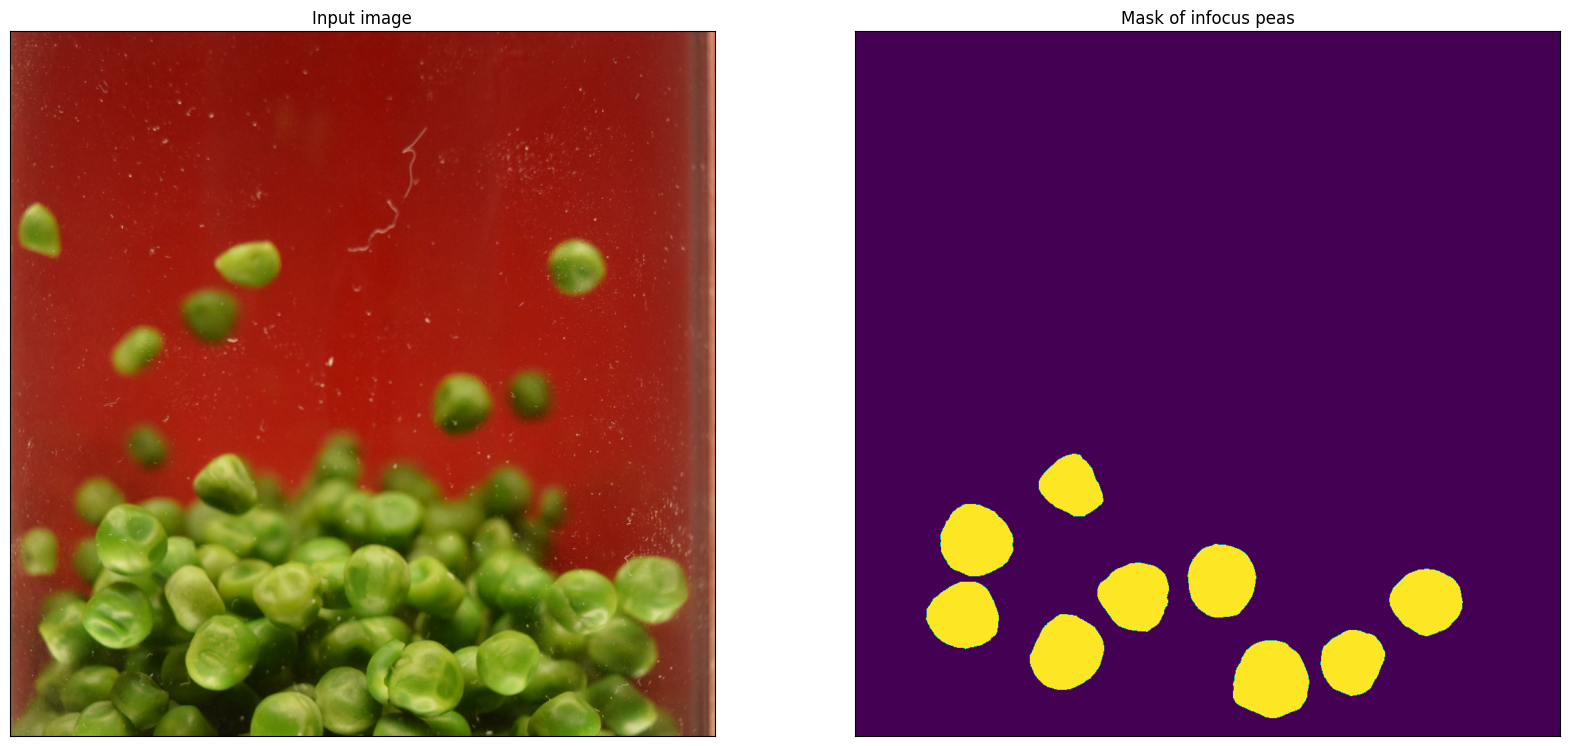

In [9]:
# Preview sample image and segmentation mask.
show_images_with_title([images[0], masks[0]], ['Input image',  'Mask of infocus peas'])

---
## Exercise 2: Build a TensorFlow Input Pipeline that Normalizes Images and Splits Mask Channels

In this exercise, you’ll enhance your TensorFlow input pipeline to include two essential preprocessing steps commonly used in image segmentation workflows: **image normalization** and **mask channel splitting**.

You’ll continue working with the same dataset of high-resolution RGB images and their corresponding single-channel masks. Each image is 2000×2992 pixels, captured during a green pea drying process in a fluidized bed dryer. The goal is to train a machine learning model that can segment the peas in focus—specifically, the ones touching the inspection glass, as indicated by the mask.


### Objective

Your goal is to create a performant, modular input pipeline that prepares this data for training. Unlike the first exercise, this time you will apply:

* **Image normalization** — scale pixel values to the range `[0, 1]` using a divisor of `255`.
* **Multi-class mask conversion** — transform the single-channel masks into multi-channel binary masks, where each channel represents a unique class intensity (useful for multi-class segmentation).


### Task Checklist

1. Crop a 2000×2000 region centered on the inspection glass from both the image and its mask.
2. Resize the cropped region to 1024×1024 pixels for efficient training on GPU.
3. Normalize the RGB image by dividing each pixel value by 255.
4. Split the mask into multiple binary channels based on the unique intensity values.
5. Configure the `ImageAndMaskDatasetBuilder` with:

   * `image_mask_channels=(3, 1)`
   * `normalize_image=True`
   * `normalization_divisor=255`
   * `split_mask_into_channels=True`
   * `batch_size=2`
   * `shuffle_buffer_size=10`
   * `prefetch_data=True`
6. Generate the dataset by calling `.run()` on your builder instance.


### Reminder

* The mask classes should be separated into distinct binary channels.
* Use the normalized image and split-mask to visualize a few samples to confirm correctness.
* This preprocessing ensures the dataset is **model-ready**, addressing both **performance** (through resizing and prefetching) and **semantic correctness** (via normalization and channel separation).


### Solution: Exercise 2

In [10]:
builder_2 = ImageAndMaskDatasetBuilder(
    images_directory=image_dir,
    masks_directory=mask_dir,
    image_mask_channels=(3, 1),
    final_image_shape=(1024, 1024),
    crop_image_and_mask=True,
    crop_dimension=(0, 484, 2000, 2000),
    normalize_image=True,
    normalization_divisor=255,
    split_mask_into_channels=True,
    batch_size=2,
    shuffle_buffer_size=10,
    prefetch_data=True
)

builder_2.run()


In [11]:
# Retrieve image-mask dataset
dataset_2 = builder_2.image_mask_dataset
dataset_2.element_spec

(TensorSpec(shape=(2, 1024, 1024, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(2, 1024, 1024, 2), dtype=tf.uint8, name=None))

In [12]:
images_1, masks_1 = next(iter(dataset_2.take(2)))

let us preview the unique pixel intensities that make the first image in the retrieved batch.

In [13]:
np.unique(images_1[0])

array([-1.        , -0.99607843, -0.99215686, -0.9882353 , -0.9843137 ,
       -0.98039216, -0.9764706 , -0.972549  , -0.96862745, -0.9647059 ,
       -0.9607843 , -0.95686275, -0.9529412 , -0.9490196 , -0.94509804,
       -0.9411765 , -0.9372549 , -0.93333334, -0.92941177, -0.9254902 ,
       -0.92156863, -0.91764706, -0.9137255 , -0.9098039 , -0.90588236,
       -0.9019608 , -0.8980392 , -0.89411765, -0.8901961 , -0.8862745 ,
       -0.88235295, -0.8784314 , -0.8745098 , -0.87058824, -0.8666667 ,
       -0.8627451 , -0.85882354, -0.85490197, -0.8509804 , -0.84705883,
       -0.84313726, -0.8392157 , -0.8352941 , -0.83137256, -0.827451  ,
       -0.8235294 , -0.81960785, -0.8156863 , -0.8117647 , -0.80784315,
       -0.8039216 , -0.8       , -0.79607844, -0.7921569 , -0.7882353 ,
       -0.78431374, -0.78039217, -0.7764706 , -0.77254903, -0.76862746,
       -0.7647059 , -0.7607843 , -0.75686276, -0.7529412 , -0.7490196 ,
       -0.74509805, -0.7411765 , -0.7372549 , -0.73333335, -0.72

Next, let us preview the unique pixel intensities or classes that make up the corresponding mask (0 = `background`; 1 =`infocus-pea`)

In [14]:
np.unique(masks_1[0])

array([0, 1], dtype=uint8)

Let's preview background and infocus pea channels of the first mask in the batch.

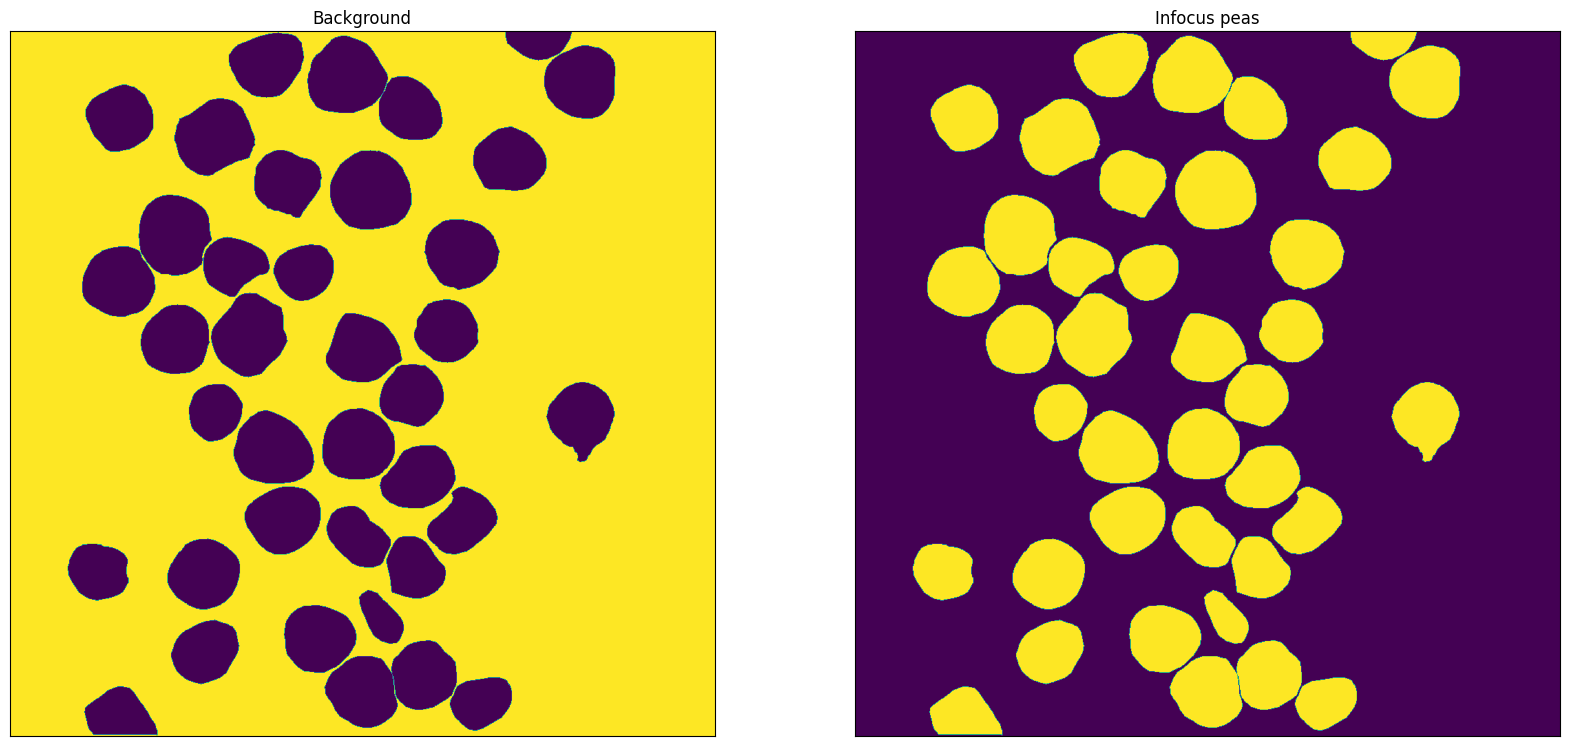

In [15]:
show_images_with_title([masks_1[0][..., 0], masks_1[0][..., 1]], ['Background',  'Infocus peas'])

---

### Conclusion

By completing this exercise, you've successfully built a **production-ready TensorFlow input pipeline** tailored for image segmentation tasks involving multi-class masks. You learned how to:

* Normalize image pixel intensities to the `[0, 1]` range — a common practice for improving model convergence.
* Automatically split segmentation masks into multiple binary channels — essential for training models on multi-class targets.
* Configure a modular pipeline with cropping, resizing, batching, shuffling, and prefetching — all key to scalable, GPU-optimized training.

This pipeline sets the foundation for training robust segmentation models on real-world datasets, especially in domains like **agriculture**, **medical imaging**, and **industrial inspection** where fine-grained annotations matter.

In the next stage, you’ll be ready to plug this pipeline directly into a model training loop using `tf.keras` or `tf.data`. Keep iterating and refining based on your target accuracy and deployment constraints.

Great work!

---